## 3. Image Preprocessing Pipeline
Our preprocessing function performs several crucial steps:
1. **Image Loading**: Reads images from the specified folder
2. **Color Space Conversion**: Converts from BGR to RGB color space
3. **Resizing**: Standardizes all images to 320x320 pixels
4. **Normalization**: Scales pixel values to range [0,1]
5. **ID Extraction**: Maintains image identification for tracking

This standardization is crucial for:
- Ensuring consistent input dimensions for our neural network
- Reducing memory usage
- Improving training efficiency

In [ ]:
def create_data_generator_with_bbox(data_folder, coco_annotations, target_size=(320, 320), batch_size=32):
    """
    Crée un générateur qui augmente à la fois les images et leurs bounding boxes
    """
    # Obtenir la liste des fichiers images
    image_files = [f for f in os.listdir(data_folder) if f.endswith('.jpg')]
    
    # Créer un mapping des images vers leurs annotations
    image_to_bbox = {}
    for ann in coco_annotations['annotations']:
        img_id = ann['image_id']
        img_info = next(img for img in coco_annotations['images'] if img['id'] == img_id)
        img_name = img_info['file_name']
        if img_name not in image_to_bbox:
            image_to_bbox[img_name] = []
        image_to_bbox[img_name].append({
            'bbox': ann['bbox'],
            'category_id': ann['category_id']
        })

    def get_image_bboxes(img_file):
        """Récupère les bounding boxes pour une image donnée"""
        bboxes = image_to_bbox.get(img_file, [])
        return [(bbox['bbox'] + [bbox['category_id']]) for bbox in bboxes]

    def augment_bbox(image, bboxes, category_ids):
        # Applique les transformations à l'image avec les labels
        augmented = transform(
            image=image,
            bboxes=bboxes,
            category_ids=category_ids
        )
        return augmented['image'], augmented['bboxes']
    
    # Création du pipeline d'augmentation avec albumentations
    transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Resize(target_size[0], target_size[1]),
    ], bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category_ids']  # Spécifie le champ pour les labels
    ))

    def generator():
        while True:
            # Charge les images et leurs annotations par batch
            for i in range(0, len(image_files), batch_size):
                batch_images = []
                batch_bboxes = []
                batch_files = image_files[i:i+batch_size]
                
                for img_file in batch_files:
                    # Charge l'image
                    image = cv2.imread(os.path.join(data_folder, img_file))
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Récupère les bounding boxes pour cette image
                    img_bboxes = get_image_bboxes(img_file)
                    
                    if img_bboxes:  # Si l'image a des bounding boxes
                        # Sépare les coordonnées des bboxes et les catégories
                        bboxes = [bbox[:4] for bbox in img_bboxes]
                        category_ids = [int(bbox[4]) for bbox in img_bboxes]
                        
                        # Applique l'augmentation
                        try:
                            aug_image, aug_bboxes = augment_bbox(
                                image=image,
                                bboxes=bboxes,
                                category_ids=category_ids
                            )
                            # Combine les bboxes augmentées avec leurs catégories
                            aug_bboxes = [list(bbox) + [cat_id] for bbox, cat_id in zip(aug_bboxes, category_ids)]
                        except ValueError as e:
                            print(f"Erreur lors de l'augmentation de {img_file}: {e}")
                            aug_image = image
                            aug_bboxes = img_bboxes
                    else:
                        aug_image = image
                        aug_bboxes = []
                    
                    batch_images.append(aug_image)
                    batch_bboxes.append(aug_bboxes)
                
                if batch_images:  # Vérifie qu'il y a des images dans le batch
                    yield np.array(batch_images), batch_bboxes

    return generator()

In [ ]:
# Chargement des annotations COCO
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Création des générateurs avec gestion des bounding boxes
train_generator = create_data_generator_with_bbox(
    data_folder=path + '/train',
    coco_annotations=coco_data,
    target_size=(320, 320),
    batch_size=32
)

In [ ]:
def visualize_augmented_data(generator, coco_data, num_samples=3):
    """
    Visualise les images augmentées avec leurs bounding boxes
    """
    # Créer le mapping des catégories
    category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Récupérer une batch d'images et annotations augmentées
        image_batch, bbox_batch = next(generator)
        
        # Prendre la première image de la batch
        img = image_batch[0]
        bboxes = bbox_batch[0]
        
        # Afficher l'image augmentée
        plt.subplot(num_samples, 1, i + 1)
        plt.title('Image augmentée')
        plt.imshow(img)
        
        # Dessiner les bounding boxes
        for bbox in bboxes:
            x, y, w, h = bbox[:4]
            category_id = int(bbox[4])
            
                # Créer le rectangle
            rect = patches.Rectangle(
                (x*img.shape[1], y*img.shape[0]),
                w*img.shape[1], h*img.shape[0],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            plt.gca().add_patch(rect)
                
            # Ajouter le label
            category_name = category_id_to_name[category_id]
            plt.text(x*img.shape[1], y*img.shape[0]-5,
                    category_name, color='r')
            
        plt.axis('off')
  
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize some augmented samples
visualize_augmented_data(train_generator, coco_data, num_samples=3)


/tmp/ipykernel_1382/2874075995.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 76722x90232 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x1500 with 3 Axes>

In [ ]:
def create_data_generator(data_folder, target_size=(320, 320), batch_size=32):
    """
    Creates and configures an image data generator with augmentation.
    
    Args:
        data_folder (str): Path to the dataset folder
        target_size (tuple): Target size for the images (height, width)
        batch_size (int): Number of images per batch
        
    Returns:
        generator: Configured data generator
    """

    # Create a DataFrame with image paths
    image_files = [f for f in os.listdir(data_folder) if f.endswith('.jpg')]
    
    # Create DataFrame with full paths
    df = pd.DataFrame({
        'filename': image_files,
        # Since we're doing object detection, we don't need class labels here
        # but the API requires a y_col, so we'll create a dummy one
        'label': [1] * len(image_files)  
    })

    # 1. Create image generator with augmentations
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 2. Create data generator from folder
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_folder,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  
        shuffle=True
    )

    return generator

In [ ]:
# Training data generator
train_folder = path + "/train"
train_generator = create_data_generator(data_folder=train_folder)

# Test data generator 
test_folder = path + "/test"
test_generator = create_data_generator(data_folder=test_folder)


Found 1661 validated image filenames.
Found 245 validated image filenames.


## Data Visualization
We implement a visualization function to:
- Display original images with their bounding box annotations
- Show category labels for each detected weed
- Verify the accuracy of our annotations
- Understand the visual characteristics of our dataset

This visual inspection helps us:
- Validate annotation quality
- Understand weed positioning and context
- Identify potential challenges for our model

In [ ]:
# Function to visualize an image with its annotations
def visualize_annotations(image_id):
    # Get image details
    img_details = image_id_to_details[image_id]
    img_path = os.path.join(path + '/train', 
                           img_details['file_name'])
    
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Get annotations for this image
    annotations = image_to_annotations.get(image_id, [])
    
    # Draw each annotation
    for ann in annotations:
        # Get the bounding box coordinates
        x, y, w, h = ann['bbox']
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add category label
        category_name = category_id_to_name[ann['category_id']]
        plt.text(x, y-5, category_name, color='r', fontsize=12)
    
    plt.title(f'Image ID: {image_id} - {img_details["file_name"]}')
    plt.axis('off')
    plt.show()

Visualizing examples of annotated images:


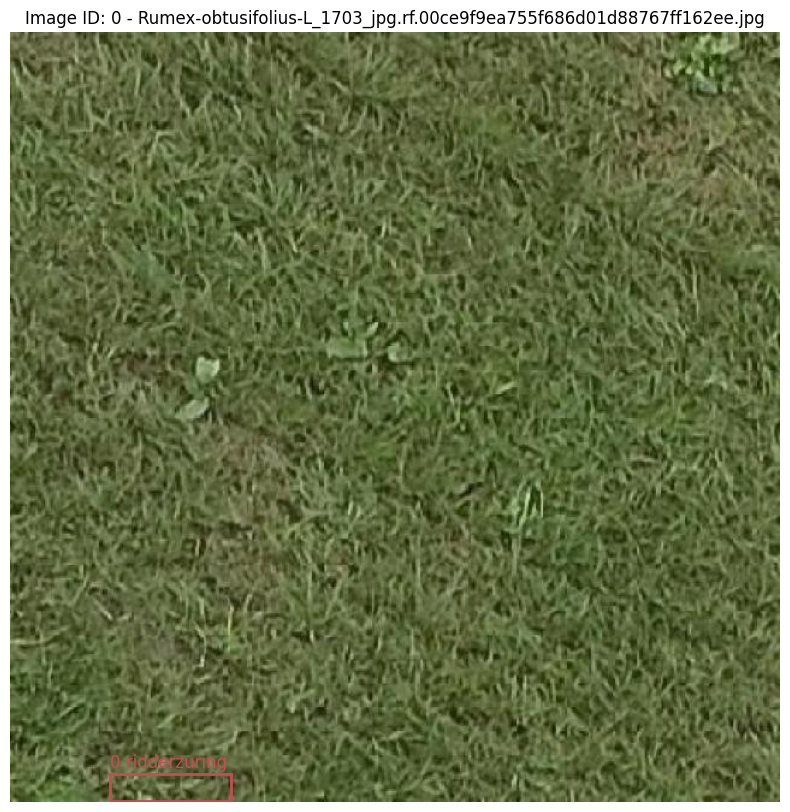

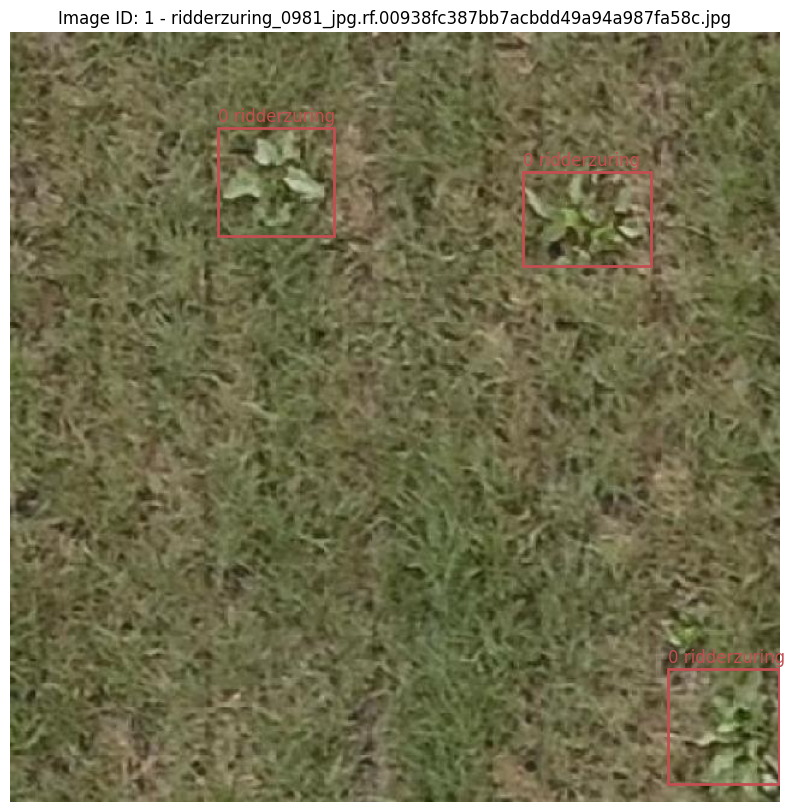

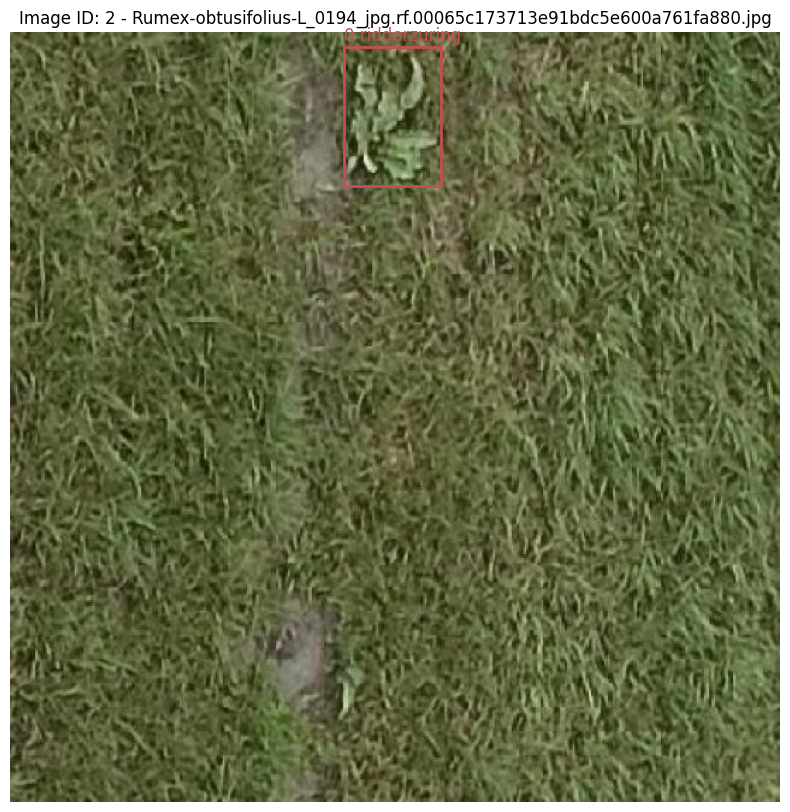


Bounding Box Statistics:
Average bounding box width: 91.73 pixels
Average bounding box height: 97.25 pixels
Average bounding box area: 9487.40 square pixels
Number of total annotations: 4199


In [ ]:
# Create a mapping from image_id to annotations
image_to_annotations = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in image_to_annotations:
        image_to_annotations[img_id] = []
    image_to_annotations[img_id].append(ann)

# Create a mapping from image_id to image details
image_id_to_details = {img['id']: img for img in coco_data['images']}

# Create a mapping from category_id to category name
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Visualize a few example images
print("Visualizing examples of annotated images:")
for image_id in list(image_to_annotations.keys())[:3]:  # Show first 3 images
    visualize_annotations(image_id)

# Print some detailed statistics about bounding boxes
print("\nBounding Box Statistics:")
widths = []
heights = []
areas = []

for ann in coco_data['annotations']:
    x, y, w, h = ann['bbox']
    widths.append(w)
    heights.append(h)
    areas.append(w * h)

print(f"Average bounding box width: {sum(widths)/len(widths):.2f} pixels")
print(f"Average bounding box height: {sum(heights)/len(heights):.2f} pixels")
print(f"Average bounding box area: {sum(areas)/len(areas):.2f} square pixels")
print(f"Number of total annotations: {len(areas)}")


## Label Processing
The label creation process involves:
- Mapping image filenames to their COCO IDs
- Extracting relevant annotations for each image
- Converting annotations into a format suitable for model training
- Handling cases where images might lack annotations

This step is crucial for:
- Preparing our ground truth data
- Ensuring proper model training
- Maintaining the connection between images and their annotations

In [ ]:
def create_labels_from_annotations(coco_data, image_filenames):
    # Create a mapping from filename to image ID
    filename_to_id = {img['file_name'].split('.')[0]: img['id'] 
                     for img in coco_data['images']}
    
    labels = []
    for filename in image_filenames:
        # Get the corresponding COCO image ID
        image_id = filename_to_id.get(filename)
        if image_id is not None:
            # Get annotations for this image
            annotations = [ann for ann in coco_data['annotations'] 
                         if ann['image_id'] == image_id]
            labels.append(annotations)
        else:
            # If no annotations found, append an empty list
            labels.append([])
    
    return labels

# Now try creating the labels again
train_labels = create_labels_from_annotations(coco_data, )
test_labels = create_labels_from_annotations(coco_data, test_image_ids)

TypeError: create_labels_from_annotations() missing 1 required positional argument: 'image_filenames'

## Model Architecture Design
Our initial model implements:
- Data augmentation techniques to increase training data variety
- A sequential CNN architecture for object detection
- Multiple convolutional and pooling layers for feature extraction
- Dense layers for final predictions

Data augmentation includes:
- Horizontal flipping for orientation invariance
- Slight rotation to handle tilted weeds
- Zoom variations to handle size differences

This architecture serves as our baseline model before moving to more sophisticated approaches.

In [ ]:
# 1. Conversion des labels en format approprié
def convert_labels_to_array(labels, num_categories):
    num_samples = len(labels)
    # Format: [x, y, w, h, one_hot_encoded_categories]
    label_array = np.zeros((num_samples, 4 + num_categories))
    
    for i, annotation_list in enumerate(labels):
        if annotation_list:  # Si il y a des annotations
            ann = annotation_list[0]  # Prendre la première annotation
            # Coordonnées de la bbox
            label_array[i, :4] = ann['bbox']
            # One-hot encoding de la catégorie
            label_array[i, 4 + ann['category_id']] = 1
    
    return label_array

# 2. Conversion des labels
num_categories = len(coco_data['categories'])
train_labels_array = convert_labels_to_array(train_labels, num_categories)
test_labels_array = convert_labels_to_array(test_labels, num_categories)

In [ ]:
def diagnostic_data(train_images, train_labels_array, test_images, test_labels_array):
    print("=== DIAGNOSTIC DES DONNÉES ===\n")
    
    # 1. Format des données d'entrée
    print("Format des données:")
    print(f"Train images shape: {train_images.shape}")
    print(f"Train labels shape: {train_labels_array.shape}")
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels_array.shape}\n")
    
    # 2. Valeurs des images
    print("Statistiques des images:")
    print(f"Train images - min: {train_images.min():.4f}, max: {train_images.max():.4f}, mean: {train_images.mean():.4f}")
    print(f"Test images - min: {test_images.min():.4f}, max: {test_images.max():.4f}, mean: {test_images.mean():.4f}\n")
    
    # 3. Analyse des labels
    print("Analyse des labels:")
    # Séparer bbox et classes
    train_bbox = train_labels_array[:, :4]
    train_classes = train_labels_array[:, 4:]
    
    print("\nBounding boxes (premières 4 colonnes):")
    print(f"Min: {train_bbox.min():.4f}")
    print(f"Max: {train_bbox.max():.4f}")
    print(f"Mean: {train_bbox.mean():.4f}")
    print(f"Nombre de zéros: {(train_bbox == 0).sum()}")
    
    print("\nClasses (colonnes restantes):")
    print(f"Nombre de classes uniques: {len(np.unique(np.argmax(train_classes, axis=1)))}")
    print(f"Distribution des classes: {np.bincount(np.argmax(train_classes, axis=1))}")
    print(f"Somme par ligne (devrait être 1): {np.unique(train_classes.sum(axis=1))}")
    
    # 4. Vérification des NaN et Inf
    print("\nVérification des valeurs problématiques:")
    print(f"NaN dans train_images: {np.isnan(train_images).any()}")
    print(f"NaN dans train_labels: {np.isnan(train_labels_array).any()}")
    print(f"Inf dans train_images: {np.isinf(train_images).any()}")
    print(f"Inf dans train_labels: {np.isinf(train_labels_array).any()}")

# Pour une loss typique, les valeurs devraient être:
# - Entre 0 et 10 pour une loss combinée (classification + régression)
# - Diminuer progressivement pendant l'entraînement
# - Relativement stables entre train et validation

# Utilisation:
diagnostic_data(train_images, train_labels_array, test_images, test_labels_array)

=== DIAGNOSTIC DES DONNÉES ===

Format des données:
Train images shape: (1661, 320, 320, 3)
Train labels shape: (1661, 6)
Test images shape: (245, 320, 320, 3)
Test labels shape: (245, 6)

Statistiques des images:
Train images - min: 0.0000, max: 1.0000, mean: 0.3549
Test images - min: 0.0000, max: 0.9882, mean: 0.3559

Analyse des labels:

Bounding boxes (premières 4 colonnes):
Min: 0.0000
Max: 637.0000
Mean: 168.7284
Nombre de zéros: 465

Classes (colonnes restantes):
Nombre de classes uniques: 2
Distribution des classes: [   6 1655]
Somme par ligne (devrait être 1): [0. 1.]

Vérification des valeurs problématiques:
NaN dans train_images: False
NaN dans train_labels: False
Inf dans train_images: False
Inf dans train_labels: False


In [ ]:
def custom_loss(y_true, y_pred):
    # Séparation bbox et classification
    bbox_true = y_true[:, :4]
    bbox_pred = y_pred[:, :4]
    class_true = y_true[:, 4]  # Maintenant un seul scalaire
    class_pred = y_pred[:, 4]  # Maintenant un seul scalaire
    
    # Loss bbox (maintenant avec données normalisées)
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred))
    
    # Loss classification avec binary_crossentropy au lieu de categorical_crossentropy
    class_loss = tf.keras.losses.binary_crossentropy(
        class_true, 
        tf.nn.sigmoid(class_pred)  # sigmoid au lieu de softmax
    )
    
    # Pondération des deux losses
    return bbox_loss + 2.0 * class_loss


In [ ]:
# 2. AJOUTER ICI : Suppression des échantillons de classe 0
print("Avant filtrage :")
print(f"Nombre d'images d'entraînement : {len(train_images)}")
print(f"Distribution des classes : {np.bincount(np.argmax(train_labels_array[:, 4:], axis=1))}\n")

# Identifier les indices de la classe majoritaire (classe 1)
majority_indices = np.where(np.argmax(train_labels_array[:, 4:], axis=1) == 1)[0]

# Filtrer les images et labels
train_images = train_images[majority_indices]
train_labels_array = train_labels_array[majority_indices]

# Supprimer la colonne de la classe 0 (garder seulement les coordonnées bbox et la classe 1)
train_labels_array = train_labels_array[:, [0,1,2,3,5]]

# Faire la même chose pour le test set
test_majority_indices = np.where(np.argmax(test_labels_array[:, 4:], axis=1) == 1)[0]
test_images = test_images[test_majority_indices]
test_labels_array = test_labels_array[test_majority_indices]
test_labels_array = test_labels_array[:, [0,1,2,3,5]]

print("Après filtrage :")
print(f"Nombre d'images d'entraînement : {len(train_images)}")
print(f"Shape des labels : {train_labels_array.shape}")

Avant filtrage :
Nombre d'images d'entraînement : 1661
Distribution des classes : [   6 1655]

Après filtrage :
Nombre d'images d'entraînement : 1655
Shape des labels : (1655, 5)


In [ ]:
# Solution : Normalisation des bounding boxes
def normalize_bbox(labels_array, img_size=(320, 320)):
    normalized_labels = labels_array.copy()
    # Normaliser x et width par la largeur de l'image
    normalized_labels[:, 0] = labels_array[:, 0] / img_size[0]
    normalized_labels[:, 2] = labels_array[:, 2] / img_size[0]
    # Normaliser y et height par la hauteur de l'image
    normalized_labels[:, 1] = labels_array[:, 1] / img_size[1]
    normalized_labels[:, 3] = labels_array[:, 3] / img_size[1]
    return normalized_labels

# Appliquer la normalisation
train_labels_array = normalize_bbox(train_labels_array)
test_labels_array = normalize_bbox(test_labels_array)

In [ ]:
# 3. Définition du modèle CNN basique
model_basic = Sequential([
    # Première couche de convolution
    Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3)),
    MaxPooling2D((2, 2)),
    
    # Deuxième couche de convolution
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Troisième couche de convolution
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Quatrième couche de convolution
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Aplatissement
    Flatten(),
    
    # Couches denses
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5)  # 4 pour bbox + 1 pour la classe restante (au lieu de 6)
])

In [ ]:
# 4. Compilation du modèle
model_basic.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=custom_loss,
    metrics=[
        tf.keras.metrics.MeanSquaredError(name='bbox_mse'),
        tf.keras.metrics.BinaryAccuracy(name='class_accuracy')  
    ]
)

# 5. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# 6. Entraînement du modèle
history_basic = model_basic.fit(
    train_images,
    train_labels_array,  # Utilisation du nouveau format
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 666ms/step - bbox_mse: 2.2437 - class_accuracy: 0.2122 - loss: 0.6561 - val_bbox_mse: 7.9265 - val_class_accuracy: 0.2012 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 686ms/step - bbox_mse: 6.3014 - class_accuracy: 0.2088 - loss: 0.2049 - val_bbox_mse: 8.0423 - val_class_accuracy: 0.2012 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 669ms/step - bbox_mse: 6.8929 - class_accuracy: 0.2092 - loss: 0.2036 - val_bbox_mse: 6.3021 - val_class_accuracy: 0.2012 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 620ms/step - bbox_mse: 8.2118 - class_accuracy: 0.2079 - loss: 0.1897 - val_bbox_mse: 9.7066 - val_class_accuracy: 0.2012 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - bbox_mse: 9.9519 - class_accuracy: 0.2029 - loss: 0.1919 - val_bbox_mse: 8.8072 - val_class_accuracy: 0.2012 - val_lo

In [ ]:
# 1. Fonction de visualisation modifiée
def visualize_predictions(model, images, labels, num_samples=5):
    # Sélectionner des échantillons aléatoires
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for idx in indices:
        image = images[idx]
        true_label = labels[idx]
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        
        # Extraire les coordonnées
        true_bbox = true_label[:4]
        pred_bbox = pred[:4]
        
        # Afficher l'image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        # Rectangle vrai (vert)
        plt.gca().add_patch(plt.Rectangle((true_bbox[0]*320, true_bbox[1]*320),
                                        true_bbox[2]*320, true_bbox[3]*320,
                                        fill=False, color='g', linewidth=2))
        plt.title('Vérité terrain')
        
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        # Rectangle prédit (rouge)
        plt.gca().add_patch(plt.Rectangle((pred_bbox[0]*320, pred_bbox[1]*320),
                                        pred_bbox[2]*320, pred_bbox[3]*320,
                                        fill=False, color='r', linewidth=2))
        plt.title(f'Prédiction (Conf: {pred[4]:.2f})')
        plt.show()

In [ ]:
def evaluate_model(model, test_images, test_labels):
    try:
        print("Début des prédictions...")
        predictions = model.predict(test_images, verbose=0)  # Désactive la barre de progression
        
        print("\nCalcul des métriques...")
        # Métriques pour les bounding boxes
        bbox_mse = np.mean(np.square(test_labels[:, :4] - predictions[:, :4]))
        bbox_mae = np.mean(np.abs(test_labels[:, :4] - predictions[:, :4]))
        
        # Métriques pour la classification
        y_true = test_labels[:, 4]
        y_pred = (predictions[:, 4] > 0.5).astype(int)  # Seuil à 0.5
        
        # Calculer IoU (Intersection over Union)
        def calculate_iou(box1, box2):
            try:
                x1 = max(box1[0], box2[0])
                y1 = max(box1[1], box2[1])
                x2 = min(box1[0] + box1[2], box2[0] + box2[2])
                y2 = min(box1[1] + box1[3], box2[1] + box2[3])
                
                intersection = max(0, x2 - x1) * max(0, y2 - y1)
                area1 = box1[2] * box1[3]
                area2 = box2[2] * box2[3]
                union = area1 + area2 - intersection
                
                return intersection / (union + 1e-6)
            except Exception as e:
                print(f"Erreur dans le calcul IoU: {e}")
                return 0
        
        # Calculer IoU moyen avec gestion d'erreurs
        ious = []
        for i in range(len(test_labels)):
            try:
                iou = calculate_iou(test_labels[i, :4], predictions[i, :4])
                ious.append(iou)
            except Exception as e:
                print(f"Erreur pour l'échantillon {i}: {e}")
                ious.append(0)
        
        mean_iou = np.mean(ious)
        
        print("\nÉvaluation du modèle:")
        print(f"MSE Bounding Box: {bbox_mse:.4f}")
        print(f"MAE Bounding Box: {bbox_mae:.4f}")
        print(f"IoU moyen: {mean_iou:.4f}")
        print(f"Précision de détection (IoU > 0.5): {np.mean(np.array(ious) > 0.5):.4f}")
        
        # Afficher quelques statistiques supplémentaires
        print("\nStatistiques des prédictions:")
        print(f"Shape des prédictions: {predictions.shape}")
        print(f"Min/Max bbox prédites: {predictions[:, :4].min():.4f}/{predictions[:, :4].max():.4f}")
        print(f"Min/Max scores de classification: {predictions[:, 4].min():.4f}/{predictions[:, 4].max():.4f}")
        
        return {
            'bbox_mse': bbox_mse,
            'bbox_mae': bbox_mae,
            'mean_iou': mean_iou,
            'detection_accuracy': np.mean(np.array(ious) > 0.5)
        }
        
    except Exception as e:
        print(f"Erreur dans l'évaluation: {e}")
        print(f"Shape des données de test: {test_images.shape}")
        print(f"Shape des labels de test: {test_labels.shape}")
        return None

# Utilisation
print("\nÉvaluation détaillée:")
metrics = evaluate_model(model_basic, test_images, test_labels_array)


Évaluation détaillée:
Début des prédictions...
Erreur dans l'évaluation: local variable 'batch_outputs' referenced before assignment
Shape des données de test: (0, 320, 320, 3)
Shape des labels de test: (0, 5)


2024-12-15 18:55:32.554028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# 3. Utilisation

print("\nÉvaluation détaillée:")
metrics = evaluate_model(model_basic, test_images, test_labels_array)


Évaluation détaillée:


2024-12-15 18:54:40.808592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

## code i ll maybe use 

Aucune image de classe 0 trouvée!


## Other Models


In [ ]:
# Clear CUDA cache
torch.cuda.empty_cache()